In [1]:
%pip install -r requirements.txt

  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
   ---------------------------------------- 0.0/376.0 MB ? eta -:--:--
   ---------------------------------------- 0.8/376.0 MB 5.6 MB/s eta 0:01:08
   ---------------------------------------- 2.1/376.0 MB 5.6 MB/s eta 0:01:07
   ---------------------------------------- 3.9/376.0 MB 6.3 MB/s eta 0:00:59
    --------------------------------------- 5.8/376.0 MB 7.0 MB/s eta 0:00:53
    --------------------------------------- 7.9/376.0 MB 7.7 MB/s eta 0:00:48
   - -------------------------------------- 10.5/376.0 MB 8.4 MB/s eta 0:00:44
   - -------------------------------------- 13.6/376.0 MB 9.4 MB/s eta 0:00:39
   - -------------------------------------- 17.3/376.0 MB 10.4 MB/s eta 0:00:35
   -- ------------------------------------- 21.2/376.0 MB 11.4 MB/s eta 0:00:32
   -- ------------------------------------- 24.1/376.0 MB 11.6 MB/s eta 0:00:31
   -- ------------------------------------- 25.7/376.0 MB 11.6 MB/s eta 0:00:3


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import os
import kagglehub
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import VotingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import optuna

# Download latest version
# === Download Dataset ===
path = kagglehub.dataset_download("thedevastator/higher-education-predictors-of-student-retention")
csv_file = [f for f in os.listdir(path) if f.endswith(".csv")][0]
df = pd.read_csv(os.path.join(path, csv_file))

In [5]:
# Encode categorical columns
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Features and labels
X = df.drop(columns=['Target'])
y = LabelEncoder().fit_transform(df['Target'])  # target must be numerical

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from ucimlrepo import fetch_ucirepo
import pandas as pd

dataset = fetch_ucirepo(id=697)
X = dataset.data.features
y = dataset.data.targets
print(f"Features shape: {X.shape}, Target shape: {y.shape}")

print(X.columns.tolist())

Features shape: (4424, 36), Target shape: (4424, 1)
['Marital Status', 'Application mode', 'Application order', 'Course', 'Daytime/evening attendance', 'Previous qualification', 'Previous qualification (grade)', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Admission grade', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'Age at enrollment', 'International', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)', 'Unemployment rat

In [10]:
# Simple preprocessing: encode targets and split
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

# After your split...
total = X.shape[0]
train_pct = X_train.shape[0] / total * 100
test_pct  = X_test.shape[0]  / total * 100

print(f"Train: {X_train.shape} ({train_pct:.1f}%), Test: {X_test.shape} ({test_pct:.1f}%)")


Train: (3539, 36), Test: (885, 36)
Train: (3539, 36) (80.0%), Test: (885, 36) (20.0%)


c:\Users\brizz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


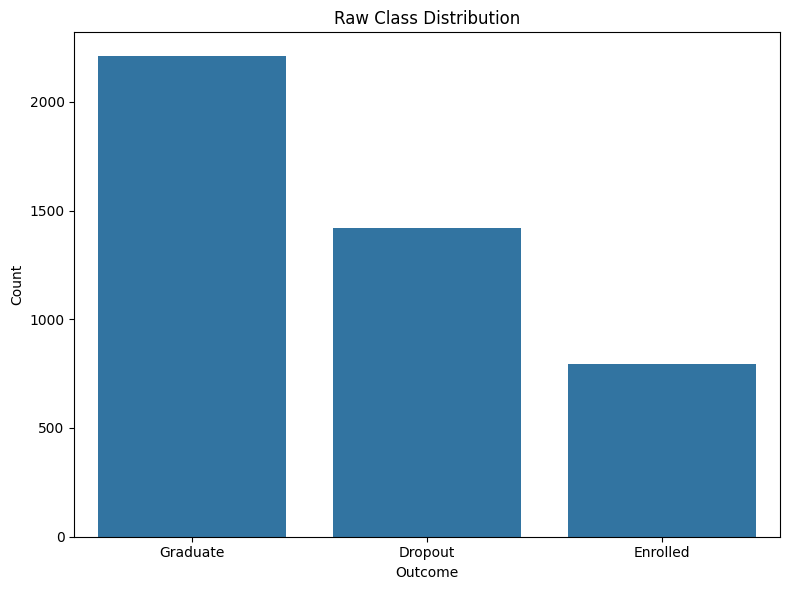

Current counts per class:
outcome
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64

Additional samples needed to balance all classes to 2209 each:
outcome
Graduate       0
Dropout      788
Enrolled    1415
Name: count, dtype: int64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1) Build a DataFrame for the raw labels (before encoding)
df_labels = pd.DataFrame({'outcome': le.inverse_transform(y_enc)})

# 2) Plot the class distribution
plt.figure(figsize=(8, 6))
sns.countplot(
    x='outcome',
    data=df_labels,
    order=df_labels['outcome'].value_counts().index
)
plt.title('Raw Class Distribution')
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 3) Compute counts per class
counts = df_labels['outcome'].value_counts()
print("Current counts per class:")
print(counts)

# 4) How many to add to match the largest class
max_count = counts.max()
needed = max_count - counts
print("\nAdditional samples needed to balance all classes to", max_count, "each:")
print(needed)


{'uci_id': 697, 'name': "Predict Students' Dropout and Academic Success", 'repository_url': 'https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success', 'data_url': 'https://archive.ics.uci.edu/static/public/697/data.csv', 'abstract': "A dataset created from a higher education institution (acquired from several disjoint databases) related to students enrolled in different undergraduate degrees, such as agronomy, design, education, nursing, journalism, management, social service, and technologies.\nThe dataset includes information known at the time of student enrollment (academic path, demographics, and social-economic factors) and the students' academic performance at the end of the first and second semesters. \nThe data is used to build classification models to predict students' dropout and academic sucess. The problem is formulated as a three category classification task, in which there is a strong imbalance towards one of the classes.", 'area': 'Social Sc

C:\Users\brizz\AppData\Local\Temp\ipykernel_22836\3413215898.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(x=["Dropout", "Enrolled", "Graduate"], y=data_pie.values, palette="pastel")


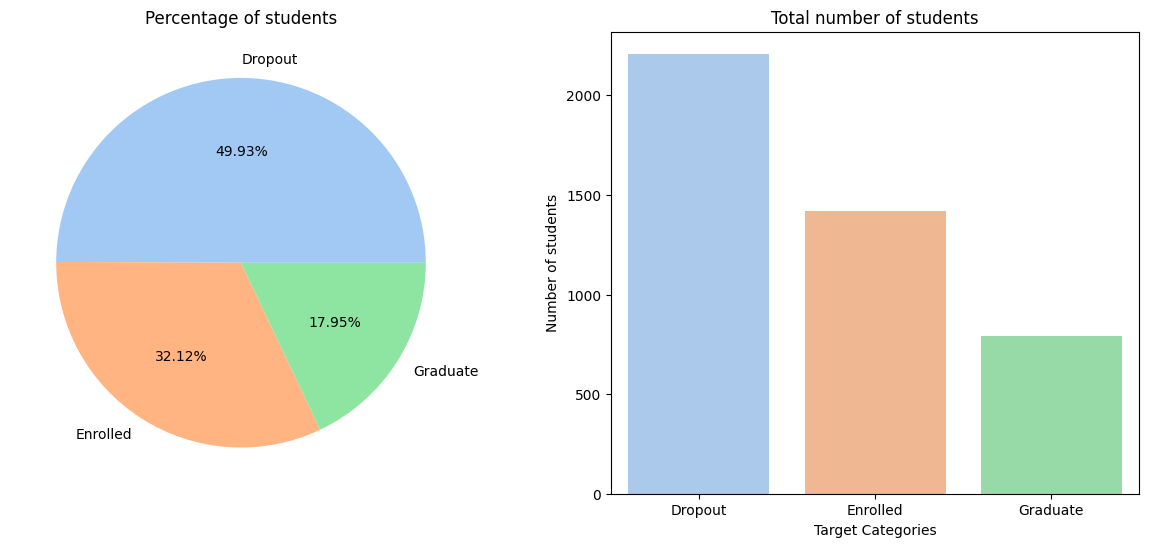

In [27]:
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.feature_selection import SelectKBest, f_classif, RFE, mutual_info_classif, SelectFromModel
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import warnings


# fetch dataset 
predict_students_dropout_and_academic_success = fetch_ucirepo(id=697) 

# data (as pandas dataframes) 
data_features = predict_students_dropout_and_academic_success.data.features 
data_targets = predict_students_dropout_and_academic_success.data.targets 
  
# metadata 
print(predict_students_dropout_and_academic_success.metadata) 

# variable information 
print(predict_students_dropout_and_academic_success.variables) 


data_pie = data_targets['Target'].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.pie(data_pie,  autopct="%.2f%%", labels=["Dropout", "Enrolled", "Graduate"],colors=sns.color_palette('pastel'))
ax1.set_title('Percentage of students')

ax2 = sns.barplot(x=["Dropout", "Enrolled", "Graduate"], y=data_pie.values, palette="pastel")
ax2.set(xlabel='Target Categories', ylabel='Number of students')
ax2.set_title('Total number of students')

plt.show()

### Univariate Outlier Detection

In [30]:

numeric_cols = data_features.select_dtypes(include=np.number).columns

# Z-score method
z_scores = data_features[numeric_cols].apply(zscore)
outliers_z = (np.abs(z_scores) > 3).sum().sort_values(ascending=False)
print("Outliers (Z-score method):\n", outliers_z)

# IQR method
Q1 = data_features[numeric_cols].quantile(0.25)
Q3 = data_features[numeric_cols].quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = ((data_features[numeric_cols] < (Q1 - 1.5 * IQR)) |
                (data_features[numeric_cols] > (Q3 + 1.5 * IQR))).sum().sort_values(ascending=False)
print("Outliers (IQR method):\n", outliers_iqr)


Outliers (Z-score method):
 Previous qualification                            308
Course                                            227
Father's occupation                               177
Curricular units 1st sem (credited)               149
Application order                                 138
Marital Status                                    126
Mother's occupation                               112
International                                     110
Curricular units 2nd sem (credited)               110
Curricular units 1st sem (enrolled)               106
Age at enrollment                                 101
Curricular units 2nd sem (without evaluations)     94
Curricular units 2nd sem (enrolled)                82
Nacionality                                        74
Curricular units 1st sem (without evaluations)     62
Curricular units 1st sem (approved)                61
Curricular units 1st sem (evaluations)             60
Educational special needs                          51


In [31]:
import numpy as np
import pandas as pd
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# ─── A) After you’ve done your stratified split ───
#    (you already have X_train, X_test as DataFrames,
#     y_train, y_test as numpy arrays or lists of strings)

import numpy as np

# After your train_test_split → you have y_train, y_test as numpy arrays

# 1) Inspect the unique values
unique_vals = np.unique(y_train)
print("Unique y_train values:", unique_vals)

# 2) If they're already in {0,1,2}, just cast to int and move on;
#    otherwise wrap+map as before.
if set(unique_vals).issubset({0, 1, 2}):
    y_train_enc = y_train.astype(int)
    y_test_enc  = y_test.astype(int)
    print("Labels already numeric, skipping map.")
else:
    # your old mapping logic
    import pandas as pd
    label_map = {'dropout': 0, 'enrolled': 1, 'graduate': 2}
    s_train = pd.Series(y_train, name='outcome')
    s_test  = pd.Series(y_test,  name='outcome')
    y_train_enc = s_train.map(label_map)
    y_test_enc  = s_test.map(label_map)

    # catch any unmapped labels
    unmapped_train = s_train[y_train_enc.isna()].unique()
    unmapped_test  = s_test [y_test_enc.isna()].unique()
    if len(unmapped_train):
        raise ValueError(f"Train labels not in map: {unmapped_train}")
    if len(unmapped_test):
        raise ValueError(f"Test  labels not in map: {unmapped_test}")

    y_train_enc = y_train_enc.astype(int).to_numpy()
    y_test_enc  = y_test_enc.astype(int).to_numpy()

# 3) Quick sanity check
from collections import Counter
print("Encoded train counts:", Counter(y_train_enc))
print("Encoded test  counts:",  Counter(y_test_enc))


# ─── B) One-hot encode your FEATURES ───
X_train_enc = pd.get_dummies(X_train, drop_first=True)
X_test_enc  = pd.get_dummies(X_test,  drop_first=True) \
                    .reindex(columns=X_train_enc.columns, fill_value=0)

# ─── C) Show counts before SMOTE ───
print("\nBefore SMOTE:", Counter(y_train_enc))

# ─── D) Apply plain SMOTE on the TRAINING data only ───
sm   = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_enc, y_train_enc)
print("After SMOTE: ", Counter(y_res))

# ─── E) (Optional) Print your full/train/res counts side-by-side ───
print("\nFull dataset counts:")
print(df_labels['outcome'].value_counts().sort_index())

print("\nTraining split counts (80% stratified):")
train_counts = pd.Series(y_train_enc, name='outcome').value_counts().sort_index()
print(train_counts)

print("\nAfter SMOTE (all up-sampled to majority class):")
res_counts = pd.Series(y_res, name='outcome').value_counts().sort_index()
print(res_counts)

# ─── F) Now y_res is a clean integer array 0/1/2 and X_res is numeric,
#      you can plug X_res, y_res into your Optuna tune_* functions, CV, etc.

Unique y_train values: [0 1 2]
Labels already numeric, skipping map.
Encoded train counts: Counter({np.int64(2): 1767, np.int64(0): 1137, np.int64(1): 636})
Encoded test  counts: Counter({np.int64(2): 442, np.int64(0): 284, np.int64(1): 159})


ValueError: Data must be 1-dimensional, got ndarray of shape (3540, 36) instead

In [ ]:
import optuna
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


# ─── 3) Set up a stratified CV splitter ───
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ─── 4) Define tuning functions for Optuna ───
def tune_xgb(trial):
    params = {
        'n_estimators':       trial.suggest_int('n_estimators', 50, 300),
        'max_depth':          trial.suggest_int('max_depth', 3, 10),
        'learning_rate':      trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'subsample':          trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree':   trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma':              trial.suggest_float('gamma', 0, 5),
        'verbosity':          0,
        'objective':          'multi:softprob',
        'num_class':          3,
        'eval_metric':        'mlogloss',
        'random_state':       42
    }
    model = XGBClassifier(**params)
    return cross_val_score(model, X_res, y_res, cv=cv, scoring='f1_macro', n_jobs=-1).mean()

def tune_lgb(trial):
    params = {
        'n_estimators':     trial.suggest_int('n_estimators', 50, 300),
        'max_depth':        trial.suggest_int('max_depth', 3, 10),
        'learning_rate':    trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'num_leaves':       trial.suggest_int('num_leaves', 20, 100),
        'subsample':        trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'objective':        'multiclass',
        'num_class':        3,
        'eval_metric':      'multi_logloss',
        'verbosity':        -1,
        'random_state':     42
    }
    model = LGBMClassifier(**params)
    return cross_val_score(model, X_res, y_res, cv=cv, scoring='f1_macro', n_jobs=-1).mean()

def tune_cat(trial):
    params = {
        'iterations':    trial.suggest_int('iterations', 50, 300),
        'depth':         trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'l2_leaf_reg':   trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'loss_function': 'MultiClass',
        'verbose':       False,
        'random_seed':   42
    }
    model = CatBoostClassifier(**params)
    return cross_val_score(model, X_res, y_res, cv=cv, scoring='f1_macro', n_jobs=-1).mean()

# ─── 5) Run Optuna studies ───
studies = {}
for name, fn in [('XGB', tune_xgb), ('LGB', tune_lgb), ('CAT', tune_cat)]:
    study = optuna.create_study(direction='maximize')
    study.optimize(fn, n_trials=20)
    studies[name] = study
    print(f"Best {name} F1_macro: {study.best_value:.4f}")


[I 2025-05-04 21:05:43,311] A new study created in memory with name: no-name-56fdedd9-25a0-453b-8001-7053433d41b8
[I 2025-05-04 21:05:45,769] Trial 0 finished with value: 0.7889087704333834 and parameters: {'n_estimators': 127, 'max_depth': 10, 'learning_rate': 0.0013731706679715665, 'subsample': 0.8376584550250751, 'colsample_bytree': 0.7137864966599657, 'gamma': 3.2193057119014012}. Best is trial 0 with value: 0.7889087704333834.
[I 2025-05-04 21:05:48,577] Trial 1 finished with value: 0.7879716982928433 and parameters: {'n_estimators': 273, 'max_depth': 8, 'learning_rate': 0.005868102780060651, 'subsample': 0.9603413480597526, 'colsample_bytree': 0.9761467339962335, 'gamma': 3.5697657871083974}. Best is trial 0 with value: 0.7889087704333834.
[I 2025-05-04 21:05:50,262] Trial 2 finished with value: 0.7782038637063688 and parameters: {'n_estimators': 115, 'max_depth': 8, 'learning_rate': 0.003862917151570991, 'subsample': 0.6176247146485949, 'colsample_bytree': 0.8396574769850721, 'g

Best XGB F1_macro: 0.8554


[I 2025-05-04 21:06:16,683] Trial 0 finished with value: 0.7913498031178857 and parameters: {'n_estimators': 104, 'max_depth': 7, 'learning_rate': 0.010117023592726088, 'num_leaves': 57, 'subsample': 0.9737735313437299, 'colsample_bytree': 0.7830327768472772}. Best is trial 0 with value: 0.7913498031178857.
[I 2025-05-04 21:06:17,701] Trial 1 finished with value: 0.8197681719293779 and parameters: {'n_estimators': 157, 'max_depth': 4, 'learning_rate': 0.06571939862762792, 'num_leaves': 84, 'subsample': 0.6285585598231616, 'colsample_bytree': 0.7646396532386609}. Best is trial 1 with value: 0.8197681719293779.
[I 2025-05-04 21:06:18,679] Trial 2 finished with value: 0.76863664454171 and parameters: {'n_estimators': 253, 'max_depth': 3, 'learning_rate': 0.013860378615243332, 'num_leaves': 84, 'subsample': 0.984317181322421, 'colsample_bytree': 0.6418296899023838}. Best is trial 1 with value: 0.8197681719293779.
[I 2025-05-04 21:06:22,391] Trial 3 finished with value: 0.7898717918667717 a

Best LGB F1_macro: 0.8499


[I 2025-05-04 21:07:05,983] Trial 0 finished with value: 0.7496968365056175 and parameters: {'iterations': 95, 'depth': 9, 'learning_rate': 0.009173597352829419, 'l2_leaf_reg': 0.0301377561851726}. Best is trial 0 with value: 0.7496968365056175.
[I 2025-05-04 21:07:17,630] Trial 1 finished with value: 0.7243577811851838 and parameters: {'iterations': 92, 'depth': 9, 'learning_rate': 0.0019966758944174098, 'l2_leaf_reg': 3.3737038419923446}. Best is trial 0 with value: 0.7496968365056175.
[I 2025-05-04 21:07:18,537] Trial 2 finished with value: 0.7336094539491796 and parameters: {'iterations': 59, 'depth': 4, 'learning_rate': 0.05130902594509271, 'l2_leaf_reg': 3.1519680114344855}. Best is trial 0 with value: 0.7496968365056175.
[I 2025-05-04 21:07:21,972] Trial 3 finished with value: 0.7067092359382471 and parameters: {'iterations': 233, 'depth': 6, 'learning_rate': 0.0012636864963509146, 'l2_leaf_reg': 0.05727290783361828}. Best is trial 0 with value: 0.7496968365056175.
[I 2025-05-04

Best CAT F1_macro: 0.8552


In [ ]:
# ─── 6) Instantiate tuned models ───
best_xgb = XGBClassifier(**studies['XGB'].best_params,
                         verbosity=0,
                         objective='multi:softprob',
                         num_class=3,
                         eval_metric='mlogloss',
                         random_state=42)

best_lgb = LGBMClassifier(**studies['LGB'].best_params,
                          objective='multiclass',
                          num_class=3,
                          eval_metric='multi_logloss',
                          verbosity=-1,
                          random_state=42)

best_cat = CatBoostClassifier(**studies['CAT'].best_params,
                              loss_function='MultiClass',
                              verbose=False,
                              random_seed=42)

# ─── 7) Fit & evaluate on the TEST set ───
for name, model in [('XGBoost', best_xgb),
                    ('LightGBM', best_lgb),
                    ('CatBoost', best_cat)]:
    model.fit(X_res, y_res)
    y_pred = model.predict(X_test_enc)
    print(f"\n--- {name} on Test Set ---")
    print("Accuracy:", accuracy_score(y_test_enc, y_pred))
    label_map = {0: 'Dropout', 1: 'Enrolled', 2: 'Graduate'}  # Define label_map
    print(classification_report(y_test_enc, y_pred,
                                target_names=label_map.values()))


--- XGBoost on Test Set ---
Accuracy: 0.7615819209039548
              precision    recall  f1-score   support

     Dropout       0.82      0.73      0.77       284
    Enrolled       0.50      0.51      0.50       159
    Graduate       0.82      0.88      0.85       442

    accuracy                           0.76       885
   macro avg       0.71      0.70      0.71       885
weighted avg       0.76      0.76      0.76       885


--- LightGBM on Test Set ---
Accuracy: 0.7593220338983051
              precision    recall  f1-score   support

     Dropout       0.81      0.72      0.76       284
    Enrolled       0.50      0.52      0.51       159
    Graduate       0.83      0.87      0.85       442

    accuracy                           0.76       885
   macro avg       0.71      0.70      0.71       885
weighted avg       0.76      0.76      0.76       885


--- CatBoost on Test Set ---
Accuracy: 0.7468926553672316
              precision    recall  f1-score   support

     Dr

In [ ]:
from contextlib import redirect_stdout, redirect_stderr
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report

# === StratifiedKFold CV with Voting Ensemble (logs → ensemble_logs.txt) ===
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
all_preds = []
all_true = []

with open('ensemble_logs.txt', 'w') as log_file:
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_scaled, y), start=1):
        X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
        y_train, y_val = y_enc[train_idx], y_enc[val_idx]  # Use y_enc instead of y

        ensemble = VotingClassifier(
            estimators=[
                ('lgbm', best_lgbm),
                ('xgb',  best_xgb),
                ('cat',  best_cat)
            ],
            voting='soft'
        )

        # Redirect all verbose model output into ensemble_logs.txt
        with redirect_stdout(log_file), redirect_stderr(log_file):
            ensemble.fit(X_train, y_train)
            preds = ensemble.predict(X_val)

        # Collect & print only the fold accuracy
        all_preds.extend(preds)
        all_true.extend(y_val)
        print(f"Fold {fold} Accuracy: {accuracy_score(y_val, preds):.4f}")

# === Final Evaluation (printed in -notebook) ===
print("\n=== Overall Performance ===")
print(classification_report(all_true, all_preds, target_names=le.classes_))


Fold 1 Accuracy: 0.7887
Fold 2 Accuracy: 0.7774
Fold 3 Accuracy: 0.7797
Fold 4 Accuracy: 0.7763
Fold 5 Accuracy: 0.7658

=== Overall Performance ===
              precision    recall  f1-score   support

     Dropout       0.81      0.77      0.79      1421
    Enrolled       0.58      0.38      0.46       794
    Graduate       0.80      0.93      0.86      2209

    accuracy                           0.78      4424
   macro avg       0.73      0.69      0.70      4424
weighted avg       0.76      0.78      0.76      4424



c:\Users\brizz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\brizz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Baseline MLP Test Accuracy: 0.718

Classification Report:
              precision    recall  f1-score   support

     Dropout       0.76      0.69      0.72       284
    Enrolled       0.40      0.40      0.40       159
    Graduate       0.80      0.85      0.83       442

    accuracy                           0.72       885
   macro avg       0.65      0.65      0.65       885
weighted avg       0.72      0.72      0.72       885



c:\Users\brizz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


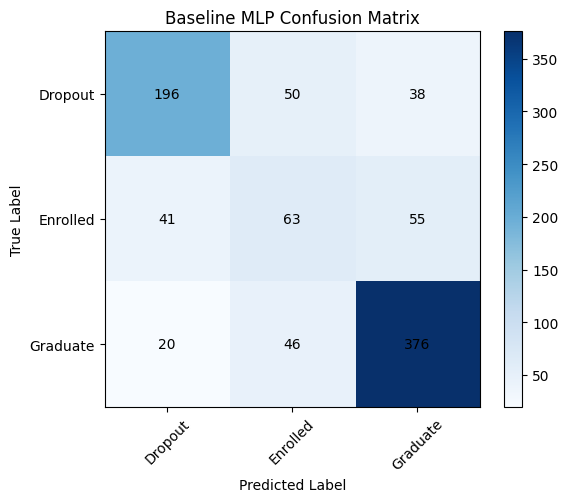

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# 1) Fetch the dataset
dataset = fetch_ucirepo(id=697)
X = dataset.data.features
y = dataset.data.targets

# 2) Encode labels to integers
le = LabelEncoder().fit(y)
y_enc = le.transform(y)

# 3) Scale features
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# 4) Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

# 5) Train baseline MLP
mlp = MLPClassifier(random_state=42, max_iter=200)
mlp.fit(X_train, y_train)

# 6) Predict & print metrics
y_pred = mlp.predict(X_test)
print(f"Baseline MLP Test Accuracy: {accuracy_score(y_test, y_pred):.3f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# 7) Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.title("Baseline MLP Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
ticks = np.arange(len(le.classes_))
plt.xticks(ticks, le.classes_, rotation=45)
plt.yticks(ticks, le.classes_)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center')
plt.colorbar()
plt.tight_layout()
plt.show()


c:\Users\brizz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


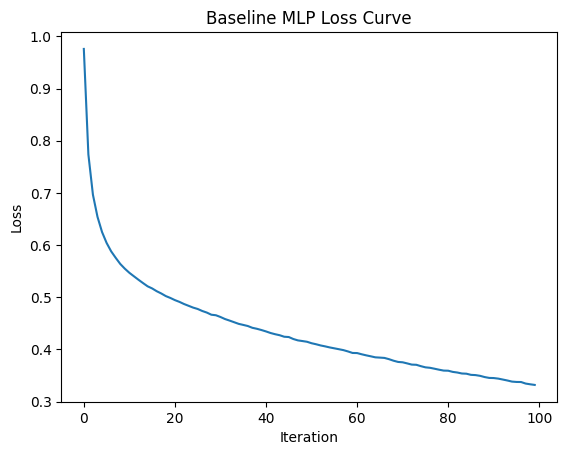

In [ ]:
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

# 1) Train a simple MLP
mlp = MLPClassifier(random_state=42, max_iter=100, verbose=False)
mlp.fit(X_train, y_train)

# 2) Plot the loss over iterations
plt.figure()
plt.plot(mlp.loss_curve_)
plt.title("Baseline MLP Loss Curve")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()
